In [1]:
# Activate environment in current folder
using Pkg
Pkg.activate(pwd())

  Activating project at `~/Desktop/School Stuff/Winter 2024/Research/2024-frequency-memory`


In [2]:
# Import packages
using Dates, Plots, DifferentialEquations, LaTeXStrings, Statistics, Measures, Peaks, DelimitedFiles, Roots, QuadGK, SpecialFunctions, Interpolations, BenchmarkTools

In [3]:
function integrate(f, p, u0, times; cb = nothing, transient = 0, int_method = Vern9(), dt = false)
    # Helper function to integrate a system of ode
    
    prob = ODEProblem(f, u0, (times[1], times[end]+transient), p, callback = cb)
    sol = solve(prob, int_method, dt = dt, saveat = times .+ transient)

    return sol
end

function palette_from_hex(hex_list)
    # Function that returns a Julia color palette based on a list of hex codes
    hash_list = [string("#", i) for i in hex_list]
    
    pal = []
    for i in hash_list
        push!(pal, parse(Colorant, i))
    end
    return palette(pal)
end

custom_palette = palette_from_hex(["009afa","e36f47","3ea44d","c371d2","ac8e18", "03aaae","ed5e93","c68225","03a98d","8e971d", "03a9cc","9b7fe9","618df6","f06073","dd65b6", "6c9f33","f61067","f7aef8","72ddf7","5e239d", "80ff72","00afb9","685044","fed9b7","f07167"])

default(
    linewidth = 2, 
    markerstrokewidth = 0,
    palette = palette_from_hex(["009afa","e36f47","3ea44d","c371d2","ac8e18", "03aaae","ed5e93","c68225","03a98d","8e971d", "03a9cc","9b7fe9","618df6","f06073","dd65b6", "6c9f33","f61067","f7aef8","72ddf7","5e239d", "80ff72","00afb9","685044","fed9b7","f07167"])
)

# Plotting formatter
cos_func(x, y) = (x, cos(y))
plt_mod = [(cos_func, 0, 1), (cos_func, 0, 2), 3, (cos_func, 0, 4)];


# coupling function
function coupling_atan(x)
    return atan(8*(1-x))/8 + x
end

# defining some functions to detect the phase differences
function center_phase(x; circ = 2*π)
    mod(x + circ/2, circ) - circ/2
end

function circ_distance(x1, x2; circ = 2*π)
    foo1 =  - center_phase.(x1) + center_phase.(x2)
    foo1 = mod.(foo1 .+ π, 2*π) .- π
end

function cluster_detect(points; max_clusters = 4, thresh = 0.05)
    # Function that takes in a list of complex numbers and figures out how many tight clusters there are

    # iterates over possible cycle lengths and checks if each cycle lengths is of order i
    for i in 1:max_clusters
        sections = points[1:i:end] # list of points with the given cycle as interval

        # check if distance of points from their mean is within treshhold
        mm = mean(sections) # average positions of points
        farthest = maximum(abs.(sections .- mm))    # highest distance between points and their average (a perfect cluster would have this as 0)
        if farthest < thresh
            return i    # if we detect that all the points are close enough to the mean, then we conclude that the system is in this cyclic regime
        end
    end

    return NaN # if we go through all the cycles and none present a cyclic behaviour, then we conclude that they are not entrained
end

function plot_traj(sol)
    # function to plot the trajectories for the unentrained system

    # trajectories
    plt1 = plot(sol, idxs = [(cos_func, 0, 1), (cos_func, 0, 2), 3])

    # points around unit circle
    circle_points = exp.((0:0.01:2*π) * 1im)
    plt2 = plot(circle_points, color = :black, label = nothing)
    # peaks index
    peaks_theta = argmaxima(cos.(sol[2, :]))
    peaks_phi = argmaxima(cos.(sol[1, :]))
    
    # Phases
    phases_theta = mod.(sol[2, peaks_phi], 2*π)
    phases_phi = mod.(sol[1, peaks_theta], 2*π)

    # Get vector of complex numbers 
    complex_theta = exp.(phases_theta*1im)
    complex_phi = exp.(phases_phi*1im)
    scatter!(plt2, complex_phi, label = "ϕ", mc = 1, markersize = 8, alpha = 0.8)
    scatter!(plt2, complex_theta, label = "θ", mc = 2, markersize = 8, alpha = 0.8)
    

    # final plot 
    l = @layout [a{0.8w} a]
    plt = plot(plt1, plt2, size = (900, 300), layout = l, aspect_ratio = 1.0)

    return plt 
end

plot_traj (generic function with 1 method)

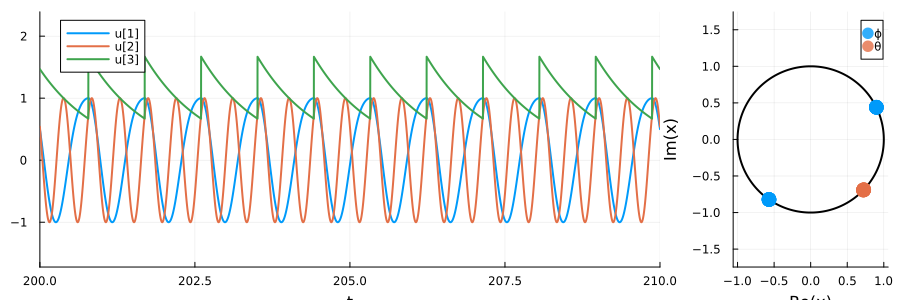

In [36]:
# Prelim test for the classical system
function f(du, u, p, t)
    du[1] = 2*π*coupling_atan(u[3]) + p[2]*sin(u[2] - u[1])
    du[2] = 2*π*p[1]
    du[3] = -p[3]*(u[3])
end

p = [2.2, 1.5, 1]

# callback
condition(u,t,integrator) = sin((u[1])/2)
affect!(integrator) = integrator.u[3] += p[3]
cb = ContinuousCallback(condition, affect!, save_positions=(false,false))


times = 0:0.001:10
#sol = integrate(f, p, [rand()*2*π, rand()*2*π, 2], cb = cb, times, transient = 100, int_method = Euler(), dt = 0.01)
sol = integrate(f, p, [0, 1, 3.65], cb = cb, times, transient = 200, int_method = Euler(), dt = 0.01)

plot_traj(sol)

In [5]:
function new_x(p, u0; plt_tr = false)
    # function that integrates the system over one period and then outputs the next value of x
    
    
    # times
    times = 0:0.001:5   # I'm assuming that it will complete a period in at most 3 units of time

    # callback
    condition(u,t,integrator) = sin((u[1])/2)
    affect!(integrator) = integrator.u[3] += p[3]
    cb = ContinuousCallback(condition, affect!, save_positions=(false,false))

    # integrate system 
    sol = integrate(f, p, u0, times, cb = cb, transient = 0, int_method = Euler(), dt = 0.001)

    # get peak for X
    idx_peaks = argmaxima(sol[3, :])

    if plt_tr==true
        plt = plot_traj(sol)
        savefig(plt, string("test_figs/", "test", ".png"))
        savefig(plt, string("test_figs/", now(), ".png"))
    end

    return sol[3, idx_peaks[1]], mod(sol[2, idx_peaks[1]], 2*π)
end

new_x([1., 1., 1.], [0., 0., 1], plt_tr = false) 

(1.2806602902455617, 1.6838936623240919)

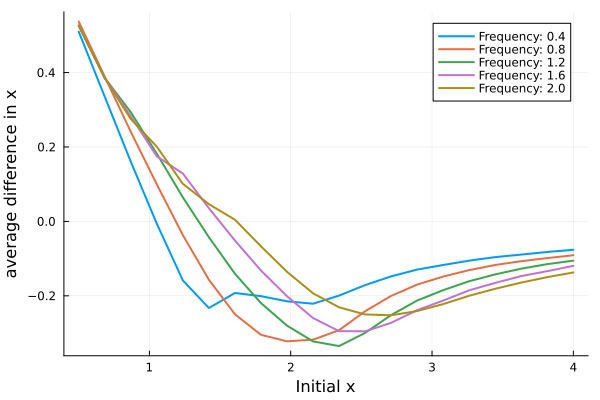

In [54]:
# Now let's scan throuh initial conditions in X
init_x = LinRange(0.5, 4, 20)
freqs = LinRange(0.4, 2, 5)

plot(xlabel = "Initial x", ylabel = "average difference in x")

for freq in freqs
    next_x = []

    for x in init_x
        push!(
            next_x, 
            minimum([new_x([freq, 1.6, 1.], [0.0, rand()*2*π, x], plt_tr = false)[1] for i in 1:50])
            )
    end

    plot!(init_x, next_x - init_x, label = string("Frequency: ", freq))
end

plot!()



In [6]:
# since the Now let's scan throuh initial conditions in X

init_x = LinRange(0.4, 4, 150)
freqs = [0.4, 1.0, 2.2]
phases = LinRange(0, 2*π, 100)
dat = fill(NaN, 2, size(phases)..., size(init_x)..., size(freqs)...)

for (i, phase) in enumerate(phases)
    for (j, x) in enumerate(init_x)
        for (k, freq) in enumerate(freqs)
            n_x, new_phase = new_x([freq, 1.5, 1.], [0.0, phase, x], plt_tr = false)
            dat[1, i, j, k] = n_x - x
            dat[2, i, j, k] = mod(new_phase - phase + π, 2*π) - π 
        end
    end
end

In [8]:
col_map_1 = cgrad([:chocolate2, :white, :navyblue], [0.48, 0.52])

In [9]:
col_map_2 = cgrad([:black, :red4, :white, :teal, :black], [0.2, 0.48, 0.52, 0.8])

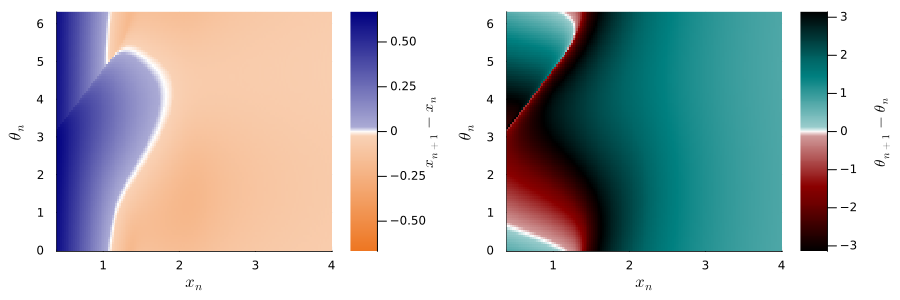

In [10]:
hm1 = dat[1, :, :, 1] # heatmap 1 (for X)
hm2 = dat[2, :, :, 1] # heatmap 2 (for theta)

max_x = maximum(abs.(hm1))

plt1 = plot(xlabel = L"x_n", ylabel = L"\theta_n")
heatmap!(plt1, init_x, phases, hm1, color = col_map_1, clims = (-max_x, max_x), colorbar_title = L"x_{n+1} - x_n")

plt2 = plot(xlabel = L"x_n", ylabel = L"\theta_n")
heatmap!(plt2, init_x, phases, hm2, color = col_map_2, clims = (-π, π), colorbar_title = L"\theta_{n+1} - \theta_n")

plot(plt1, plt2, size = (300, 100).*3., left_margin = 5mm, bottom_margin = 5mm)

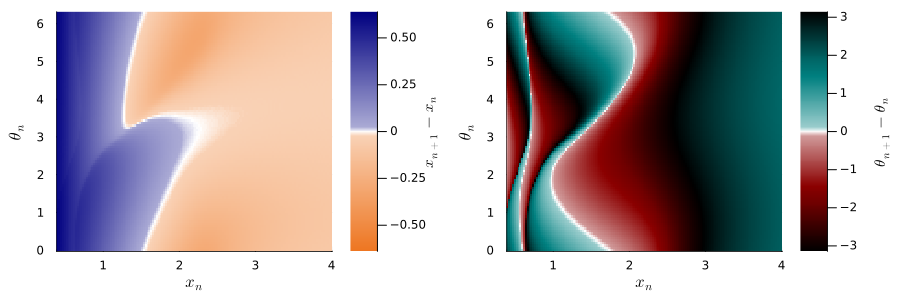

In [11]:
hm1 = dat[1, :, :, 2] # heatmap 1 (for X)
hm2 = dat[2, :, :, 2] # heatmap 2 (for theta)

max_x = maximum(abs.(hm1))

plt1 = plot(xlabel = L"x_n", ylabel = L"\theta_n")
heatmap!(plt1, init_x, phases, hm1, color = col_map_1, clims = (-max_x, max_x), colorbar_title = L"x_{n+1} - x_n")

plt2 = plot(xlabel = L"x_n", ylabel = L"\theta_n")
heatmap!(plt2, init_x, phases, hm2, color = col_map_2, clims = (-π, π), colorbar_title = L"\theta_{n+1} - \theta_n")

plot(plt1, plt2, size = (300, 100).*3., left_margin = 5mm, bottom_margin = 5mm)

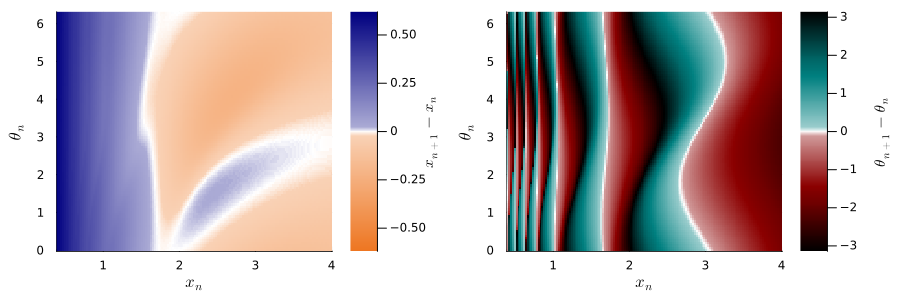

In [12]:
hm1 = dat[1, :, :, 3] # heatmap 1 (for X)
hm2 = dat[2, :, :, 3] # heatmap 2 (for theta)

max_x = maximum(abs.(hm1))

plt1 = plot(xlabel = L"x_n", ylabel = L"\theta_n")
heatmap!(plt1, init_x, phases, hm1, color = col_map_1, clims = (-max_x, max_x), colorbar_title = L"x_{n+1} - x_n")

plt2 = plot(xlabel = L"x_n", ylabel = L"\theta_n")
heatmap!(plt2, init_x, phases, hm2, color = col_map_2, clims = (-π, π), colorbar_title = L"\theta_{n+1} - \theta_n")

plot(plt1, plt2, size = (300, 100).*3., left_margin = 5mm, bottom_margin = 5mm)